# Examen práctico 
## Parcial 1 Laboratorio de Aprendizaje Estadístico
Diego Lozoya Morales | 745345

# Paqueterías

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from scipy import stats
import statsmodels.formula.api as smf
from sklearn.neighbors import KNeighborsRegressor
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

colors = ["cornflowerblue", "indianred", "darkseagreen", "plum", "dimgray"]

# Funciones

In [40]:
def calibracion(predicciones, y, bins):
    df_calibracion = pd.DataFrame({
        'predicciones':predicciones,
        'y':y
    })
    df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=bins, labels=False)+1
    grouped = df_calibracion.groupby('bins').mean()

    plt.figure(figsize=(10, 5))
    plt.plot(grouped.predicciones, grouped.y, label="Modelo", marker="o", color=colors[0])
    plt.plot(grouped.predicciones, grouped.predicciones, label="Real", marker="o", color=colors[1])
    plt.xlabel("Prediccion")
    plt.ylabel("Real")
    plt.title("Calibración")
    plt.grid()
    plt.legend()
    plt.show()

def vibariado(df, y):
    target = y.name
    num_vars = len(df.keys().drop(target))
    num_rows = (num_vars + 1) // 2 
    
    fig, axes = plt.subplots(num_rows, 2, figsize=(15, 5 * num_rows))
    axes = axes.flatten()
    
    for idx, i in enumerate(df.keys().drop(target)):
        X = df[[i]]
        model = linear_model.LinearRegression().fit(X, y)
        
        q = len(X.iloc[:, 0].unique()) if len(X.iloc[:, 0].unique()) < 5 else 10
        df[i + "_bin"] = pd.qcut(df[i], q=q, labels=False, duplicates="drop") + 1
        grouped = df.groupby(i + "_bin").mean()
        
        ax = axes[idx]
        ax.plot(grouped[i].values, grouped[target].values, color=colors[0], marker='o')
        ax.set_xlabel(f"{i} bins")
        ax.set_ylabel(target)
        ax.set_title(f"Análisis bivariado entre {i} y {target}")
        ax.grid()
        
        df.drop(columns=[i + "_bin"], inplace=True)
    
    plt.tight_layout()
    plt.show()

def comparacion(modelos, y):
     plt.figure(figsize=(10, 5))

     for i, modelo in enumerate(modelos):
          col_pred = f'predicciones_{modelo}'

          df_calibracion = pd.DataFrame({
               'predicciones': globals()[col_pred],
               'y': y
          })

          df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=10, labels=False)+1
          grouped = df_calibracion.groupby('bins').mean()
          plt.plot(grouped['predicciones'].values, grouped['y'].values, marker='o', color=colors[i], label=modelos[i])

     plt.plot(grouped['predicciones'].values, grouped['predicciones'].values, color=colors[-1], linestyle="--", label="Real", zorder=100)
     plt.xlabel("Valores predichos")
     plt.ylabel("Valores reales")
     plt.title("Comparación de modelos")
     plt.grid()
     plt.legend()
     plt.show()

def graficas_KNN(resultados, nn_opt):
     fig, axes = plt.subplots(1, 2, figsize=(15, 5))  

     axes[0].plot(resultados.nn, resultados.r2, label='real', color=colors[0], marker='o')
     axes[0].grid()
     axes[0].set_title("$R^2$ Real")
     axes[0].set_xlabel("Nearest Neighbors")
     axes[0].set_ylabel("$R^2$")

     axes[1].plot(resultados.nn, resultados.r2_train, label='train', color=colors[1], marker='o')
     axes[1].grid()
     axes[1].set_title("$R^2$ Train")
     axes[1].set_xlabel("Nearest Neighbors")
     axes[1].set_ylabel("$R^2$")

     plt.show()

     plt.figure(figsize=(15, 5))
     plt.plot(resultados.nn, resultados.r2, label='Real', color=colors[0], marker='o')
     plt.plot(resultados.nn, resultados.r2_train, label='Train', color=colors[1], marker='o')
     plt.scatter(nn_opt, max(resultados.r2), label=f'Óptimo nn = {nn_opt}', color=colors[2], s=50, zorder=3)
     plt.text(nn_opt, max(resultados.r2)-0.05, f"Máximo $R^2$", va='bottom')
     plt.grid()
     plt.legend()
     plt.title("$R^2$ Real vs Train")
     plt.xlabel("Nearest Neighbors")
     plt.ylabel("$R^2$")
     plt.show()

# Data

In [41]:
data = pd.read_csv("Data/Boston.csv")
data.head()

,Unnamed: 0,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


## Explicación variables Dataset

CRIM - per capita crime rate by town

ZN - proportion of residential land zoned for lots over 25,000 sq.ft.

INDUS - proportion of non-retail business acres per town.

CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)

NOX - nitric oxides concentration (parts per 10 million)

RM - average number of rooms per dwelling

AGE - proportion of owner-occupied units built prior to 1940

DIS - weighted distances to five Boston employment centres

RAD - index of accessibility to radial highways

TAX - full-value property-tax rate per $10,000

PTRATIO - pupil-teacher ratio by town

LSTAT - % lower status of the population

MEDV - Median value of owner-occupied homes in $1000's

## Limpieza de datos

In [42]:
data.drop('Unnamed: 0', axis=1, inplace=True)
data.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


## Variable dependiente

In [43]:
target = 'medv'
y = data[target]

# Análisis Dataset

## Correlación

<Axes: >

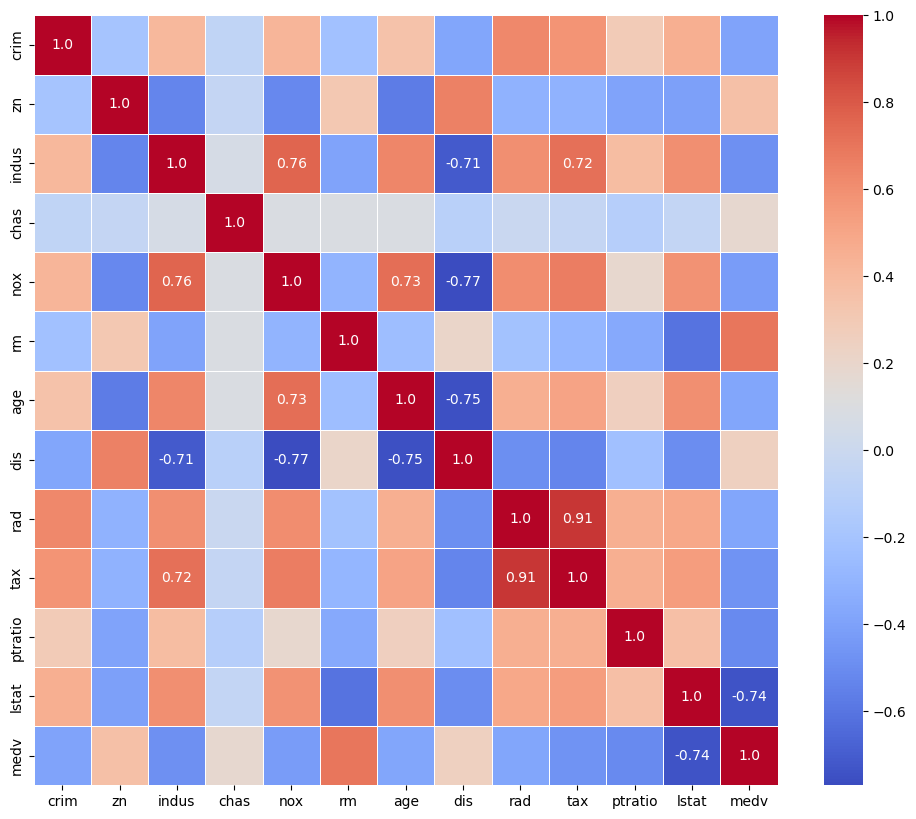

In [44]:
corr_matrix = data.corr().round(2)
mask = np.abs(corr_matrix) > 0.7
annot = np.where(mask, corr_matrix.astype(str), "")

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=annot, cmap="coolwarm", fmt="", linewidths=0.5)

In [45]:
pd.DataFrame(data.corr()[target]).sort_values(by=target, ascending=False).drop(index=target)

,medv
rm,0.695360
zn,0.360445
dis,0.249929
chas,0.175260
age,-0.376955
rad,-0.381626
crim,-0.388305
nox,-0.427321
tax,-0.468536
indus,-0.483725


## Análisis vibariado

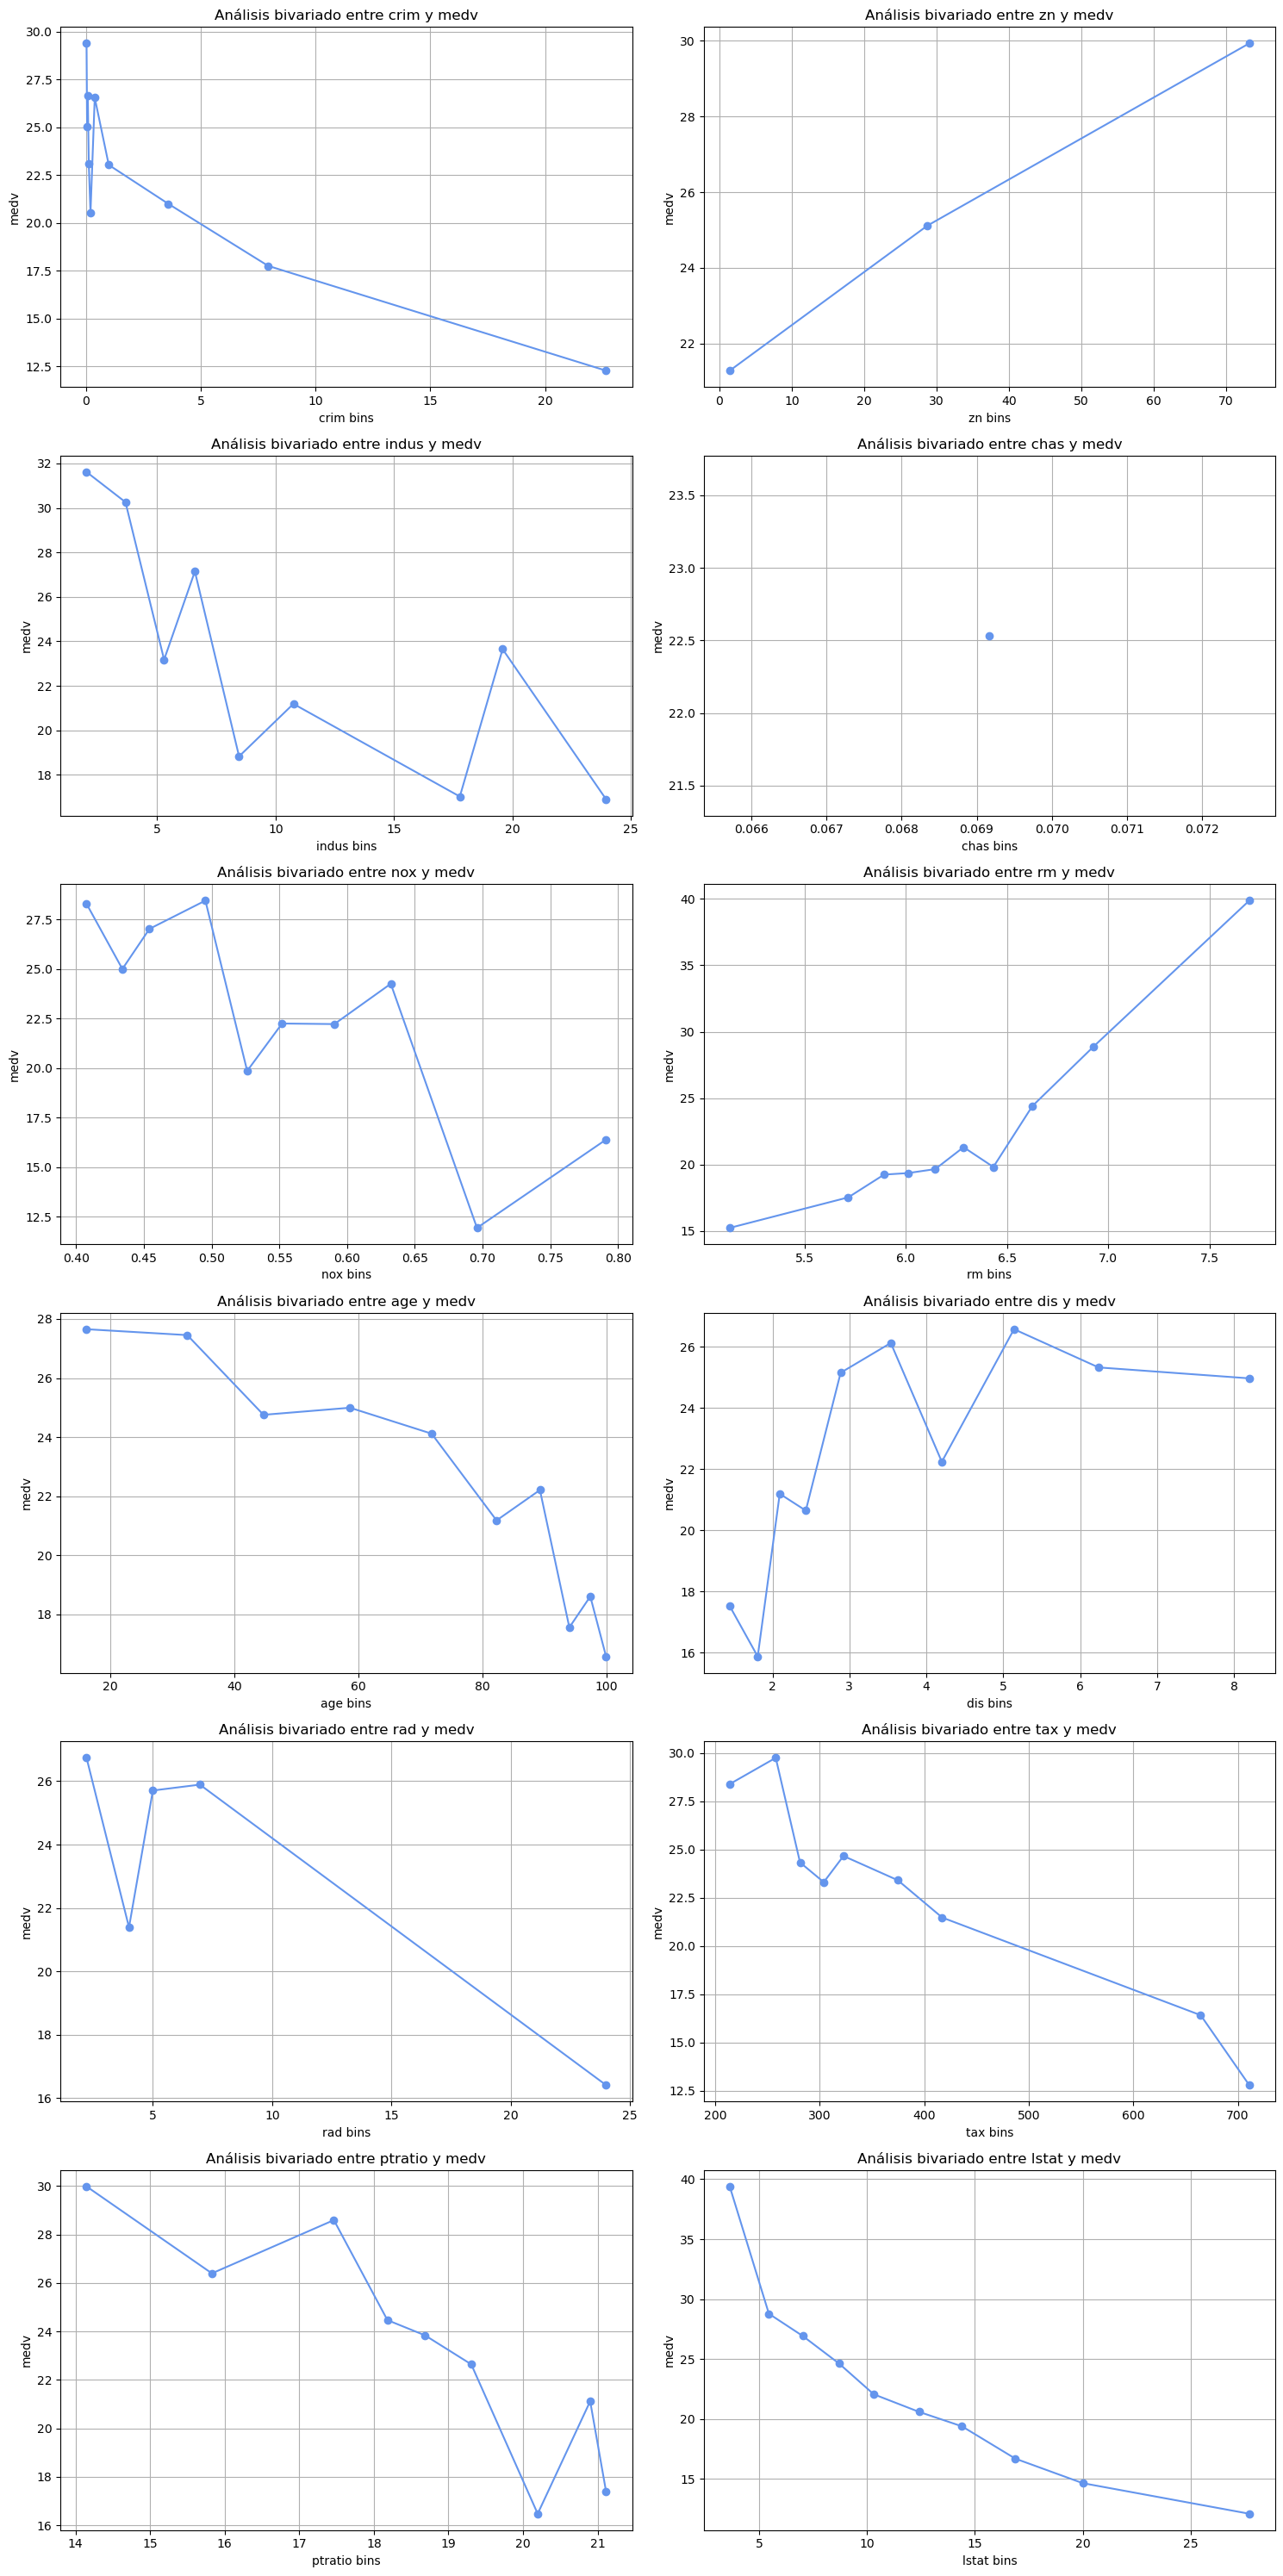

In [46]:
vibariado(data, y)

# Feature engineering

## Dummies

In [47]:
data = pd.get_dummies(data, columns=['rad'])

## Nuevas Variables
- Relación entre impuestos y accesibilidad a carreteras

In [48]:
# Nuevas Variables
data['dis_nox'] = data['dis'] / (data['nox'] + 1)

# Transformaciones
data['log_dis'] = np.log(data['dis'])
data['log_rm'] = np.log(data['rm'])
data['age_2'] = data['age'] ** 2
data['log_nox'] = np.log(data['nox'])
data['rm_2'] = data['rm'] ** 2
data['sqrt_dis'] = np.sqrt(data['dis'])
data['log_tax'] = np.log(data['tax'])

# Interacciones entre variables con relaciones no lineales
data['nox_dis'] = data['nox'] * data['dis']
data['ptratio_nox'] = data['ptratio'] * data['nox']
data['ptratio_dis'] = data['ptratio'] * data['dis']
data['tax_indus'] = data['tax'] * data['indus']

# Creación de combinaciones cuadráticas
data['nox2'] = data['nox'] ** 2
data['tax2'] = data['tax'] ** 2


## Transformaciones

- Logaritmo de la tasa de crimen per capita por ciudad
- Logaritmo de la concentración de óxido nitrico
- Cuadrado de número de cuartos promedio por vivienda
- Raíz de la distancia ponderada de 5 centros de empleo en Boston
- Logaritmo del valor total de la propiedad por la tasa de impuestos por $10,000

# Significancia de variables

In [49]:
controls = data.keys().drop(target)

result = smf.ols('medv ~ ' + '+'.join(controls), data=data).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1792.3731,368.638,4.862,0.000,1067.999,2516.747
rad_1[T.True],196.0449,40.967,4.785,0.000,115.545,276.545
rad_2[T.True],197.9256,41.005,4.827,0.000,117.351,278.500
rad_3[T.True],199.2024,40.867,4.874,0.000,118.899,279.505
rad_4[T.True],198.9120,40.995,4.852,0.000,118.358,279.466
rad_5[T.True],198.3677,40.998,4.839,0.000,117.807,278.928
rad_6[T.True],197.6244,40.884,4.834,0.000,117.287,277.961
rad_7[T.True],199.2520,40.920,4.869,0.000,118.844,279.660
rad_8[T.True],199.3494,40.867,4.878,0.000,119.046,279.653
rad_24[T.True],205.6948,41.228,4.989,0.000,124.682,286.708


# Preparación de datos

## Cross validation

In [50]:
X = data.copy().drop(target, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Scaler

In [51]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Regresión lineal múltiple

## Modelo normal

In [52]:
model = linear_model.LinearRegression().fit(X_train_scaled, y_train)
predicciones_RLM = model.predict(X_test_scaled)

r2 = r2_score(y_true=y_test, y_pred=predicciones_RLM)
print(f"R² Score: {r2:,.4f}")

mse = mean_squared_error(y_true=y_test, y_pred=predicciones_RLM)
print(f"MSE: {mse:,.4f}")

coeficientes = pd.DataFrame({
     'names': X.keys(),
     'coeficientes': model.coef_
})

print()
print(f"Intercepto del modelo: {model.intercept_:,.2f}\nCoeficientes del modelo:")
display(coeficientes)

R² Score: 0.8225
MSE: 13.2294

Intercepto del modelo: 23.02
Coeficientes del modelo:


,names,coeficientes
0,crim,-1.807072
1,zn,0.728014
2,indus,-2.942948
3,chas,0.447984
4,nox,-306.634361
5,rm,-14.461676
6,age,-2.019016
7,dis,-1280.896219
8,tax,64.651527
9,ptratio,-6.575231


### Calibración

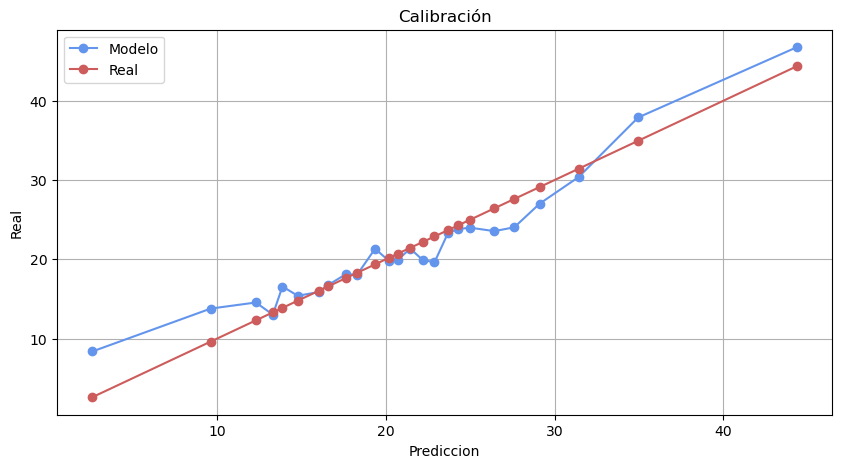

In [53]:
calibracion(predicciones_RLM, y_test, 25)

## Regularización Ridge

In [54]:
model = linear_model.Ridge().fit(X_train_scaled, y_train)
predicciones_RLM_ridge = model.predict(X_test_scaled)

r2 = r2_score(y_true=y_test, y_pred=predicciones_RLM_ridge)
print(f"R² Score: {r2:,.4f}")

mse = mean_squared_error(y_true=y_test, y_pred=predicciones_RLM_ridge)
print(f"MSE: {mse:,.4f}")

coeficientes = pd.DataFrame({
     'names': X.keys(),
     'coeficientes': model.coef_
})

print()
print(f"Intercepto del modelo: {model.intercept_:,.2f}\nCoeficientes del modelo:")
display(coeficientes)

R² Score: 0.8181
MSE: 13.5570

Intercepto del modelo: 23.02
Coeficientes del modelo:


,names,coeficientes
0,crim,-1.704008
1,zn,0.646887
2,indus,-0.457555
3,chas,0.747229
4,nox,-1.511583
5,rm,1.275851
6,age,-2.048005
7,dis,-0.530059
8,tax,0.094838
9,ptratio,-1.099621


### Calibración

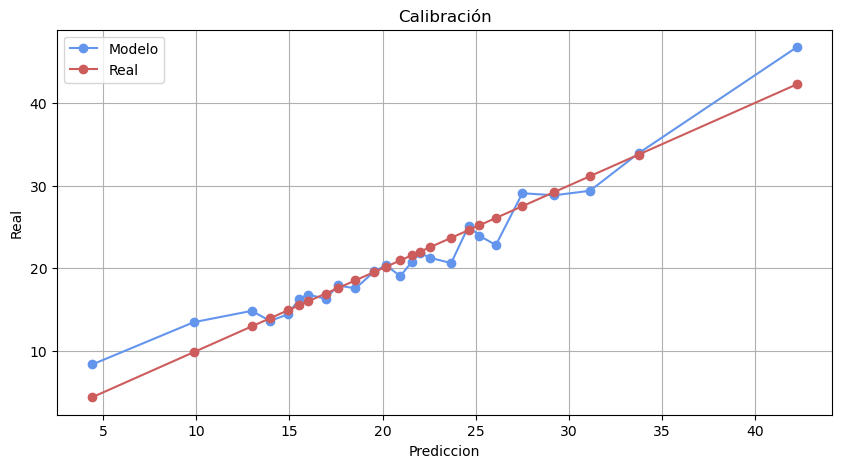

In [55]:
calibracion(predicciones_RLM_ridge, y_test, 25)

## Regularización Lasso

In [56]:
model = linear_model.Lasso().fit(X_train_scaled, y_train)
predicciones_RLM_lasso = model.predict(X_test_scaled)

r2 = r2_score(y_true=y_test, y_pred=predicciones_RLM_lasso)
print(f"R² Score: {r2:,.4f}")

mse = mean_squared_error(y_true=y_test, y_pred=predicciones_RLM_lasso)
print(f"MSE: {mse:,.4f}")

coeficientes = pd.DataFrame({
     'names': X.keys(),
     'coeficientes': model.coef_
})

print()
print(f"Intercepto del modelo: {model.intercept_:,.2f}\nCoeficientes del modelo:")
display(coeficientes)

R² Score: 0.6640
MSE: 25.0362

Intercepto del modelo: 23.02
Coeficientes del modelo:


,names,coeficientes
0,crim,-0.109342
1,zn,0.000000
2,indus,-0.000000
3,chas,0.183187
4,nox,-0.000000
5,rm,0.000000
6,age,-0.000000
7,dis,-0.000000
8,tax,-0.000000
9,ptratio,-1.155309


### Calibración

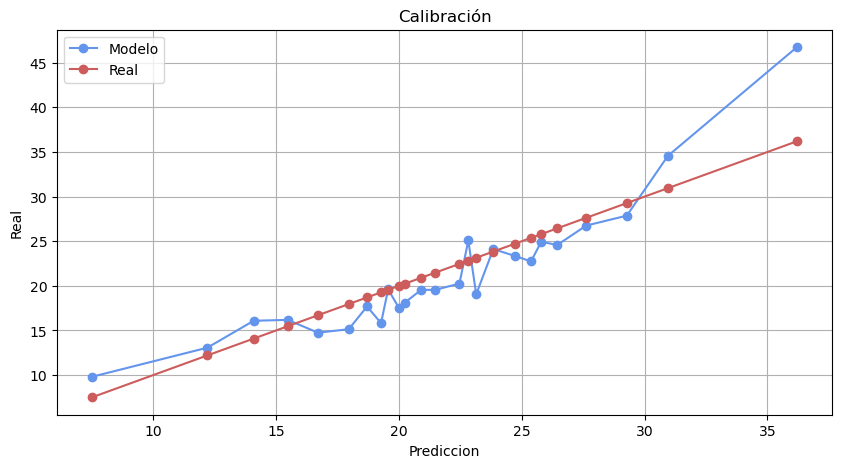

In [57]:
calibracion(predicciones_RLM_lasso, y_test, 25)

## Comparación modelos

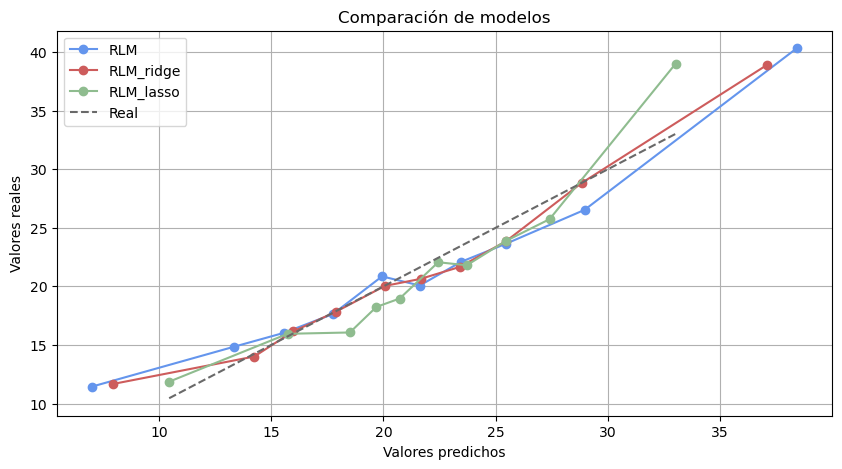

In [58]:
modelos = ['RLM', 'RLM_ridge', 'RLM_lasso']

comparacion(modelos, y_test)

# Regresión polinomial

## Grado 2

In [59]:
degree = 2

poly_features = PolynomialFeatures(degree=degree)
X_poly_train = poly_features.fit_transform(X_train_scaled)
X_poly_test = poly_features.fit_transform(X_test_scaled)

### Modelo Normal

In [60]:
model = linear_model.LinearRegression().fit(X_poly_train, y_train)
predicciones_poly2 = model.predict(X_poly_test)

r2 = r2_score(y_true=y_test, y_pred=predicciones_poly2)
print(f"R² Score: {r2:,.4f}")

mse = mean_squared_error(y_true=y_test, y_pred=predicciones_poly2)
print(f"MSE: {mse:,.4f}")

R² Score: -365,664.3621
MSE: 27,246,858.0688


#### Calibración

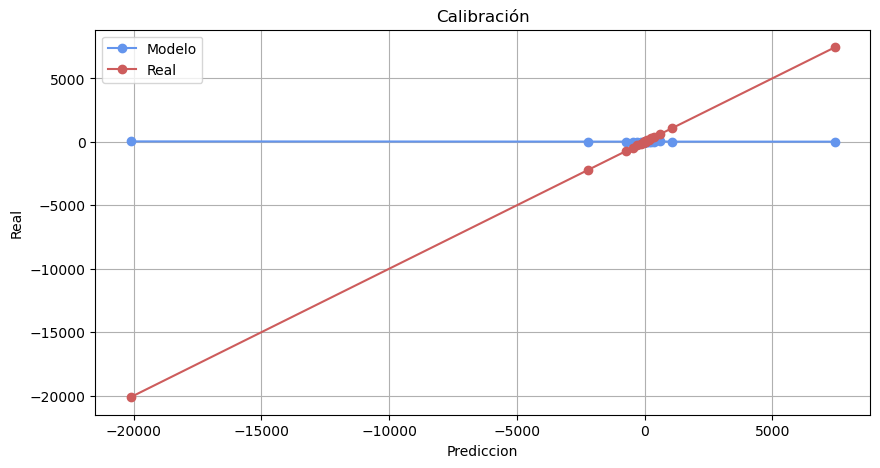

In [61]:
calibracion(predicciones_poly2, y_test, 25)

### Regularización Ridge

In [62]:
model = linear_model.Ridge().fit(X_poly_train, y_train)
predicciones_poly2_ridge = model.predict(X_poly_test)

r2 = r2_score(y_true=y_test, y_pred=predicciones_poly2_ridge)
print(f"R² Score: {r2:,.4f}")

mse = mean_squared_error(y_true=y_test, y_pred=predicciones_poly2_ridge)
print(f"MSE: {mse:,.4f}")

R² Score: 0.8900
MSE: 8.1976


#### Calibración

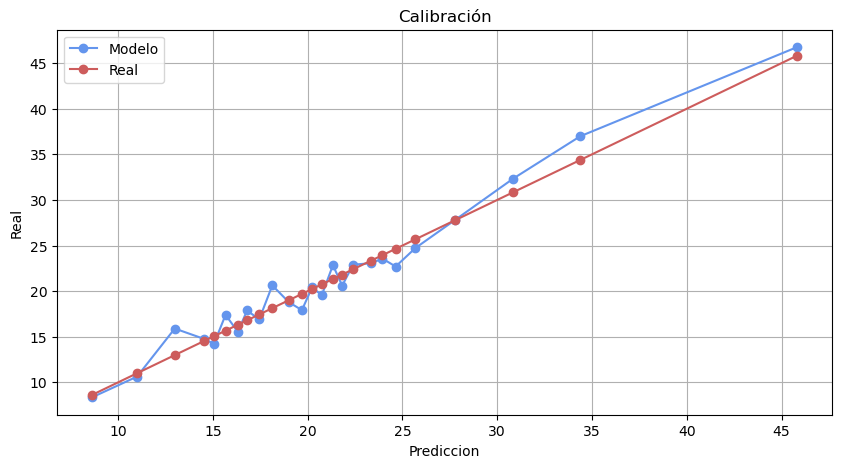

In [63]:
calibracion(predicciones_poly2_ridge, y_test, 25)

### Regularización Lasso

In [64]:
model = linear_model.Lasso().fit(X_poly_train, y_train)
predicciones_poly2_lasso = model.predict(X_poly_test)

r2 = r2_score(y_true=y_test, y_pred=predicciones_poly2_lasso)
print(f"R² Score: {r2:,.4f}")

mse = mean_squared_error(y_true=y_test, y_pred=predicciones_poly2_lasso)
print(f"MSE: {mse:,.4f}")

R² Score: 0.7556
MSE: 18.2143


#### Calibración

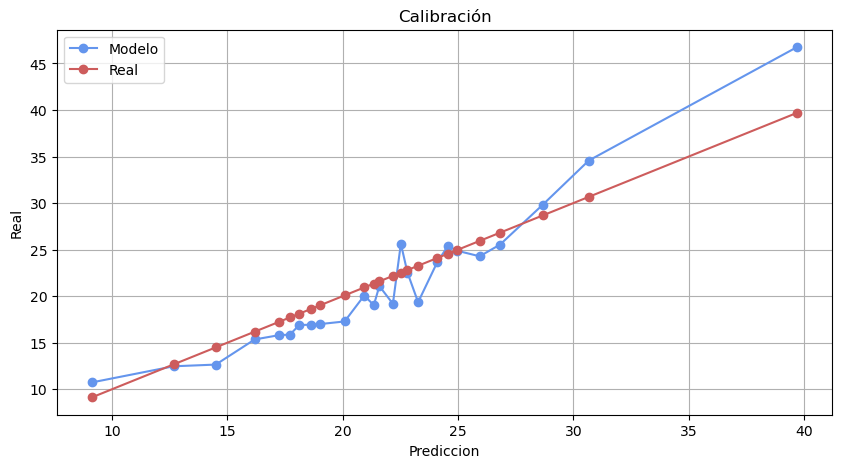

In [65]:
calibracion(predicciones_poly2_lasso, y_test, 25)

### Comparación modelos

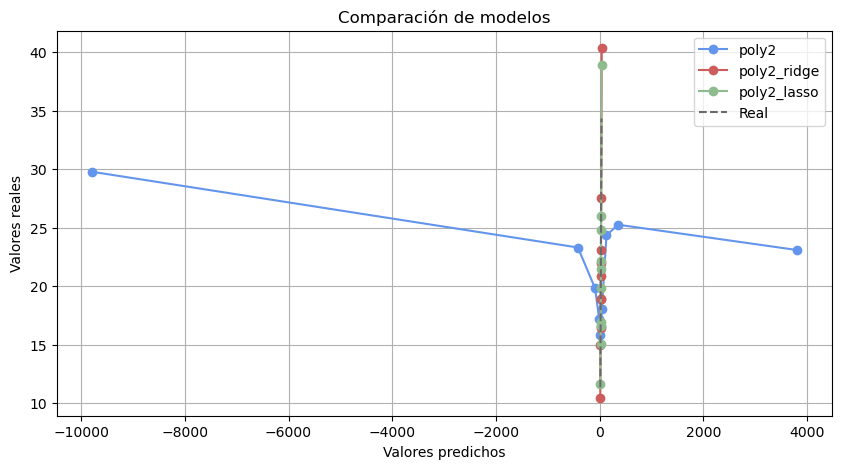

In [66]:
modelos = ['poly2', 'poly2_ridge', 'poly2_lasso']

comparacion(modelos, y_test)

## Grado 3

In [67]:
degree = 3

poly_features = PolynomialFeatures(degree=degree)
X_poly_train = poly_features.fit_transform(X_train_scaled)
X_poly_test = poly_features.fit_transform(X_test_scaled)

### Modelo Normal

In [68]:
model = linear_model.LinearRegression().fit(X_poly_train, y_train)
predicciones_poly3 = model.predict(X_poly_test)

r2 = r2_score(y_true=y_test, y_pred=predicciones_poly3)
print(f"R² Score: {r2:,.4f}")

mse = mean_squared_error(y_true=y_test, y_pred=predicciones_poly3)
print(f"MSE: {mse:,.4f}")

R² Score: -15.1978
MSE: 1,206.9495


#### Calibración

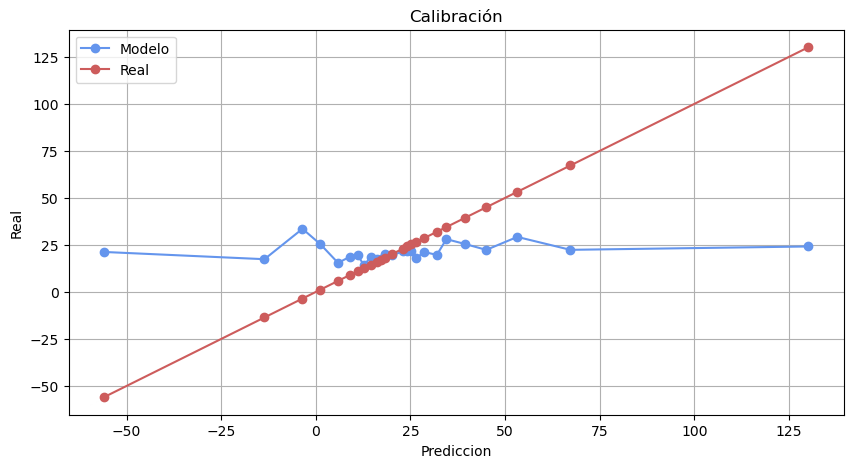

In [69]:
calibracion(predicciones_poly3, y_test, 25)

### Regularización Ridge

In [70]:
model = linear_model.Ridge().fit(X_poly_train, y_train)
predicciones_poly3_ridge = model.predict(X_poly_test)

r2 = r2_score(y_true=y_test, y_pred=predicciones_poly3_ridge)
print(f"R² Score: {r2:,.4f}")

mse = mean_squared_error(y_true=y_test, y_pred=predicciones_poly3_ridge)
print(f"MSE: {mse:,.4f}")

R² Score: -0.1804
MSE: 87.9546


#### Calibración

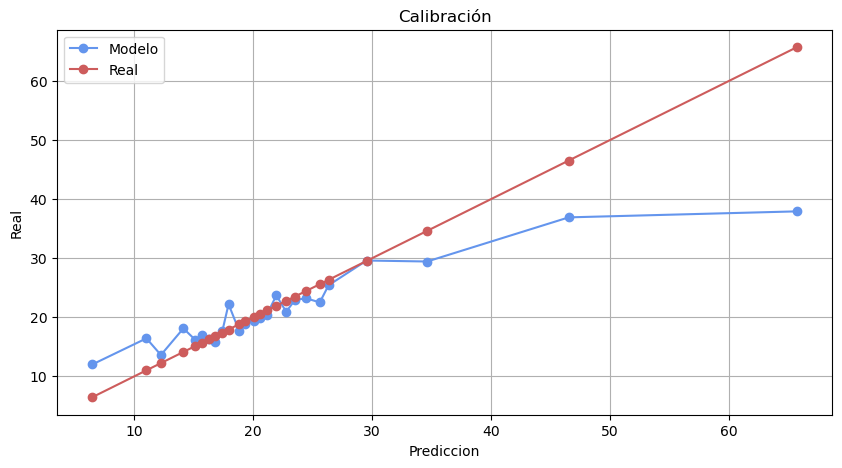

In [71]:
calibracion(predicciones_poly3_ridge, y_test, 25)

### Regularización Lasso

In [72]:
model = linear_model.Lasso().fit(X_poly_train, y_train)
predicciones_poly3_lasso = model.predict(X_poly_test)

r2 = r2_score(y_true=y_test, y_pred=predicciones_poly3_lasso)
print(f"R² Score: {r2:,.4f}")

mse = mean_squared_error(y_true=y_test, y_pred=predicciones_poly3_lasso)
print(f"MSE: {mse:,.4f}")

R² Score: 0.7482
MSE: 18.7631


#### Calibración

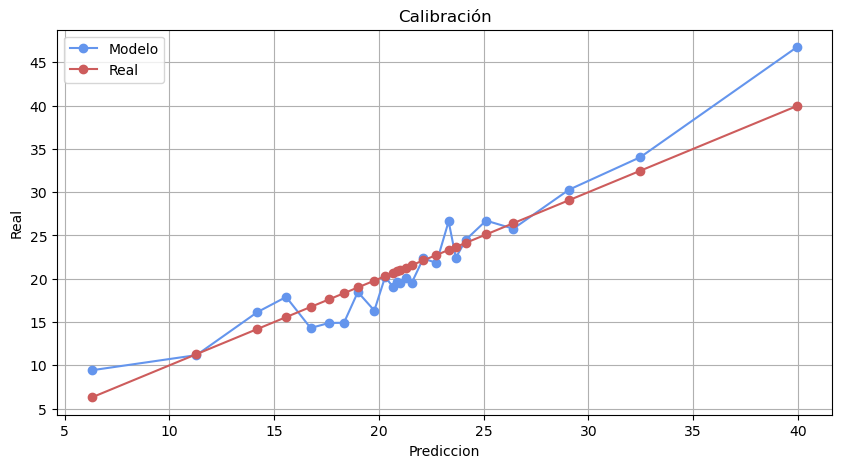

In [73]:
calibracion(predicciones_poly3_lasso, y_test, 25)

### Comparación modelos

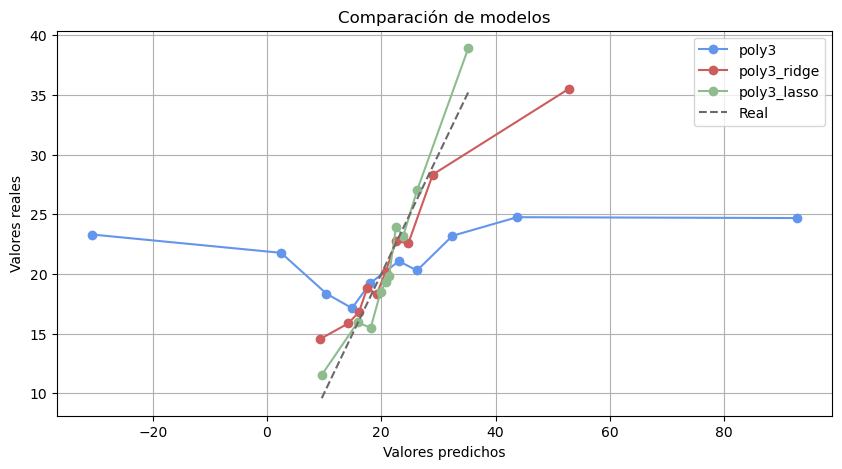

In [74]:
modelos = ['poly3', 'poly3_ridge', 'poly3_lasso']

comparacion(modelos, y_test)

# KNN

## Aproximación gráfica

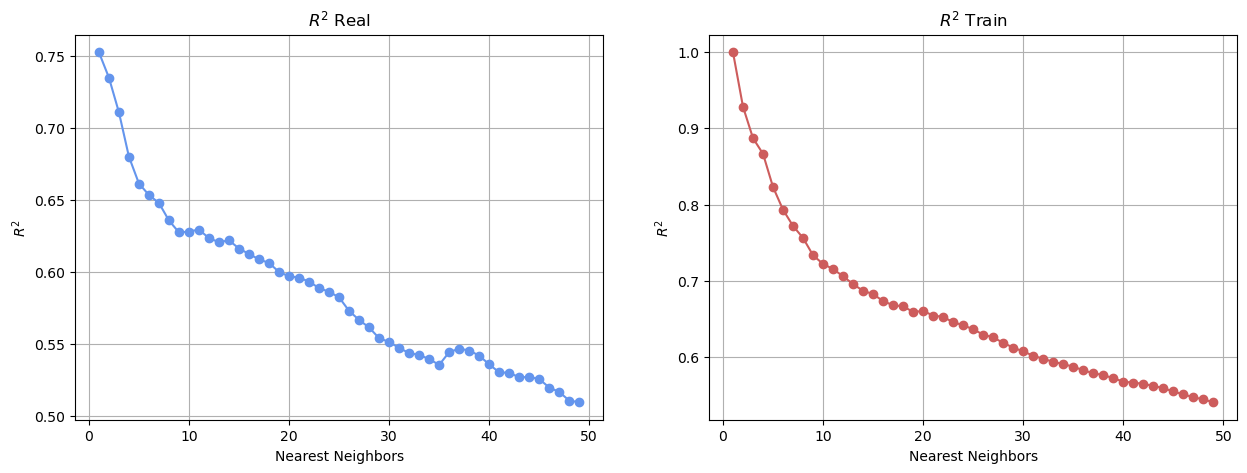

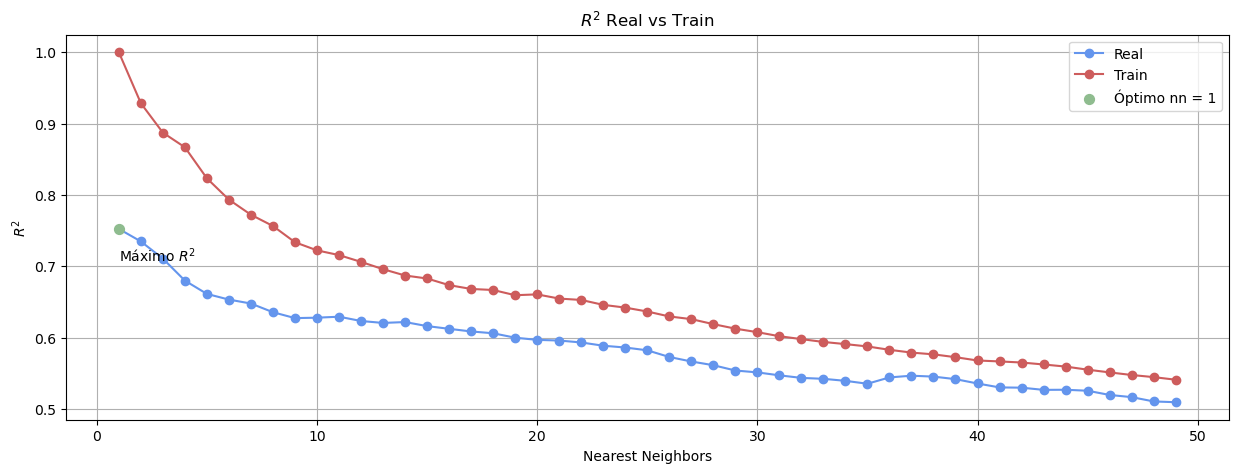

In [75]:
nn = []
r2 = []
r2_train = []
for i in range(1, 50):
    
    model = KNeighborsRegressor(n_neighbors=i).fit(X_train_scaled, y_train)
    predicciones = model.predict(X_test_scaled)

    r2.append(r2_score(y_true=y_test, y_pred=predicciones))
    nn.append(i)

    predicciones_train = model.predict(X_train_scaled)
    r2_train.append(r2_score(y_true=y_train, y_pred=predicciones_train))

resultados = pd.DataFrame({'r2': r2, 'nn': nn, 'r2_train': r2_train})

nn_opt = resultados[resultados.r2 == max(resultados.r2)].nn.values[0]

graficas_KNN(resultados, nn_opt)

## Prueba y error

In [76]:
model = KNeighborsRegressor(n_neighbors=nn_opt-1 if nn_opt > 1 else nn_opt).fit(X_train_scaled, y_train)
predicciones = model.predict(X_test_scaled)
nn_opt_nbr_minus = r2_score(y_true=y_test, y_pred=predicciones)

model = KNeighborsRegressor(n_neighbors=nn_opt).fit(X_train_scaled, y_train)
predicciones = model.predict(X_test_scaled)
nn_opt_nbr = r2_score(y_true=y_test, y_pred=predicciones)

model = KNeighborsRegressor(n_neighbors=nn_opt+1).fit(X_train_scaled, y_train)
predicciones = model.predict(X_test_scaled)
nn_opt_nbr_plus = r2_score(y_true=y_test, y_pred=predicciones)

print(f"R2 con {nn_opt-1 if nn_opt > 1 else nn_opt} neighbors: {nn_opt_nbr_minus:.4f} \nR2 con {nn_opt} neighbors: {nn_opt_nbr:.4f} \nR2 con {nn_opt+1} neighbors: {nn_opt_nbr_plus:.4f}")

R2 con 1 neighbors: 0.7524 
R2 con 1 neighbors: 0.7524 
R2 con 2 neighbors: 0.7348


# Conclusiones generales